# Step 1. Correcting Nonuniform Illumination
- Purpose: after nonuniform illumination of each frame in a movie is corrected, an algorithm that works for each frame is more likely to work for the entire movie. Hence, the job to find optimal parameters for the movie is reduced to the job to find optimal parameters for a frame.

In [1]:
from __future__ import print_function
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def DisplayImageAsArray(image, title):
    array = sitk.GetArrayFromImage(image)
    plt.imshow(array, cmap='gray')
    plt.title(title)
    plt.show()
    return

## 1.1 Read the movie.

In [3]:
imread = sitk.ImageFileReader()
imread.SetFileName( '../Movie/movie20.mha' )
movie = imread.Execute();

In [4]:
# Get the size of the movie.
(n1,n2,n3) = movie.GetSize()

## 1.2 Rescale image intensity values.

In [5]:
imadjust = sitk.RescaleIntensityImageFilter()
imadjust.SetOutputMinimum( 0 )
imadjust.SetOutputMaximum( 255 )
movie = imadjust.Execute( movie )

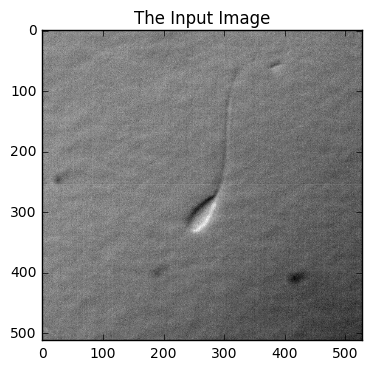

In [6]:
# Disply the first frame as an example.
I = movie[:,:,0]
DisplayImageAsArray(I, "The Input Image")

## 1.3a Apply correction to a frame.
Algorithm: 
- image_background = grayscale_opening( image )
- corrected_image = image - image_background

In [7]:
def IlluminationCorrector( I, radius ):
    # Define erosion filter.
    imerode = sitk.GrayscaleErodeImageFilter()
    imerode.SetKernelType(sitk.sitkBall)
    imerode.SetKernelRadius( radius )
    # Define dilation filters.
    imdilate = sitk.GrayscaleDilateImageFilter()
    imdilate.SetKernelType(sitk.sitkBall)
    imdilate.SetKernelRadius( radius )
    # Apply grayscale opening.
    imageA = imerode.Execute( I )
    imageB = imdilate.Execute(imageA)
    # Get corrected illumination.
    img = I - imageB
    return img, imageA, imageB

radius =  (8, 8)


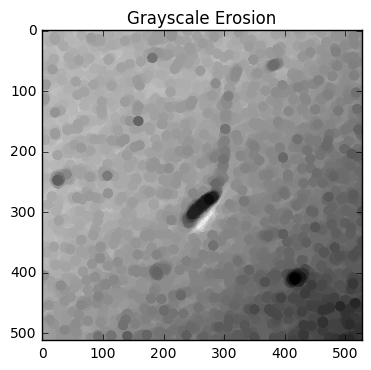

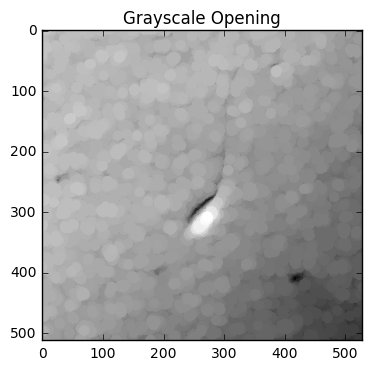

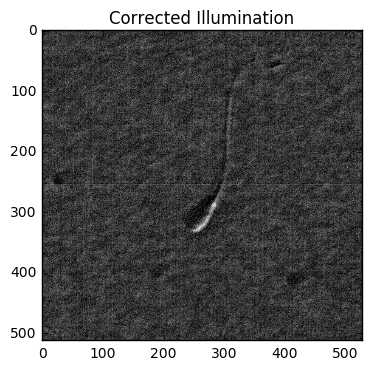

In [8]:
# Apply illumination corrector to one frame.
radius = (n1/64,n2/64)
img, imageA, imageB = IlluminationCorrector( I, radius )
print("radius = ", radius)
DisplayImageAsArray(imageA, "Grayscale Erosion")
DisplayImageAsArray(imageB, "Grayscale Opening")
DisplayImageAsArray(img, "Corrected Illumination")

radius =  (16, 16)


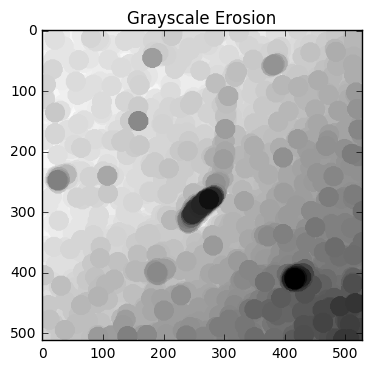

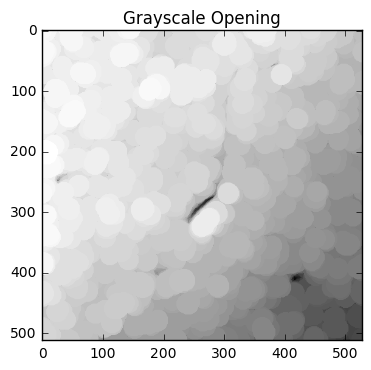

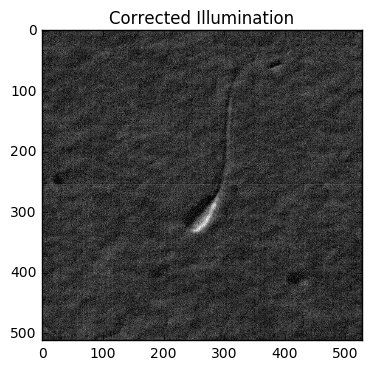

In [9]:
# Apply illumination corrector to one frame.
radius = (n1/32,n2/32)
img, imageA, imageB = IlluminationCorrector( I, radius )
print("radius = ", radius)
DisplayImageAsArray(imageA, "Grayscale Erosion")
DisplayImageAsArray(imageB, "Grayscale Opening")
DisplayImageAsArray(img, "Corrected Illumination")

radius =  (33, 32)


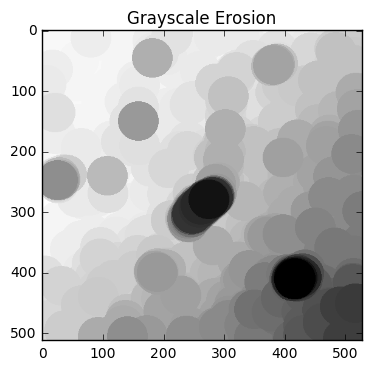

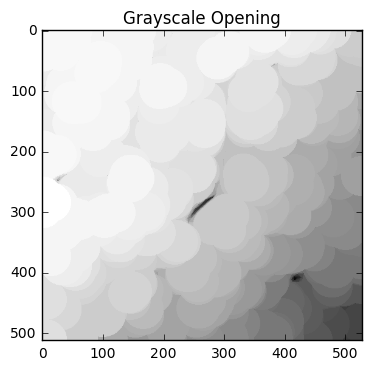

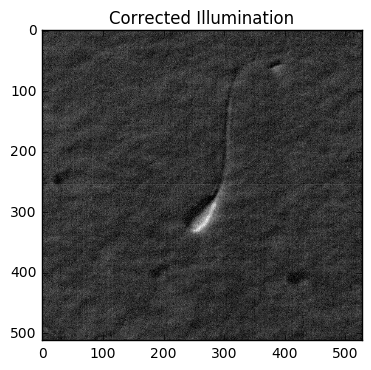

In [10]:
# Apply illumination corrector to one frame.
radius = (n1/16,n2/16)
img, imageA, imageB = IlluminationCorrector( I, radius )
print("radius = ", radius)
DisplayImageAsArray(imageA, "Grayscale Erosion")
DisplayImageAsArray(imageB, "Grayscale Opening")
DisplayImageAsArray(img, "Corrected Illumination")

### Conclusion: 
- The background intensity for the output is inversely proportional to the radius of the structuring element.
- The feature of the sperm is kept in all cases.
- The difference between the outputs in all cases is not too big. I will simply use radius = (n1/16,n1/16).

## 1.3b Apply correction to the movie frame by frame.

In [11]:
newMovie = sitk.Image(n1,n2,n3, sitk.sitkUInt16)
radius = (n1/16,n2/16)
for ii in range(n3): 
    newImage, imageA, imageB = IlluminationCorrector( movie[:,:,ii], radius )
    volume = sitk.JoinSeries(newImage)
    newMovie = sitk.Paste(newMovie, volume, volume.GetSize(), destinationIndex=[0,0,ii])

## 1.4 Write out the result. 

In [12]:
imwrite = sitk.ImageFileWriter()
imwrite.SetFileName("movieCorrectedIllunimation.mha")
imwrite.Execute(newMovie)

<SimpleITK.SimpleITK.ImageFileWriter; proxy of <Swig Object of type 'itk::simple::ImageFileWriter *' at 0x11b01bb70> >

## 1.5 Conclusion.
Correcting nonuniform illumination
- Advantage: After this algorithm has been applied to all frames in the movie, we are able to focus on one frame to develop the best segmentation method, because a set of algorithms and parameters that works for one frame now also works for the other frames. 
- Disadvantage: The time consumption for this algorithm increases as the radius of the structuring element increase.